<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Линейная-регрессия" data-toc-modified-id="Линейная-регрессия-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Линейная регрессия</a></span></li><li><span><a href="#Случайный-лес" data-toc-modified-id="Случайный-лес-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Случайный лес</a></span></li><li><span><a href="#Light-GBM" data-toc-modified-id="Light-GBM-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Light GBM</a></span></li><li><span><a href="#CatBoost" data-toc-modified-id="CatBoost-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>CatBoost</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import plotly.express as px # подключаем графическую библиотеку plotly
from IPython.display import display #импортируем метод дисплей для красивого вывода таблиц (не применяя print)
pd.set_option('display.max_columns', None) #реализуем возможность вывода всех столбцов на экран
pd.set_option('display.float_format', '{:.3f}'.format) #выводим значения float до 3 знаков после запятой
from sklearn.preprocessing import StandardScaler # для масштабирования количественных признаков
from sklearn.preprocessing import OrdinalEncoder # порядковое кодирование
from sklearn.model_selection import train_test_split # деление на 2 выборки
from sklearn.model_selection import GridSearchCV # для поиска оптимальных параметров
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error # для расчета MSE и RMSE
from sklearn.linear_model import LinearRegression # линейная регрессия
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.dummy import DummyRegressor
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
import lightgbm as lgb
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
import time
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from sklearn.model_selection import TimeSeriesSplit

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('/datasets/taxi.csv', sep=',', index_col=[0], parse_dates=[0])
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Выполним ресемплирование данных по одному часу.

In [5]:
df = df.resample('1H').sum()
display(df.head())
df.info()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


## Анализ

Проверим данные на монотонность.

In [6]:
print(df.index.is_monotonic)

True


Данные монотонны. Выведем график изменения данных.

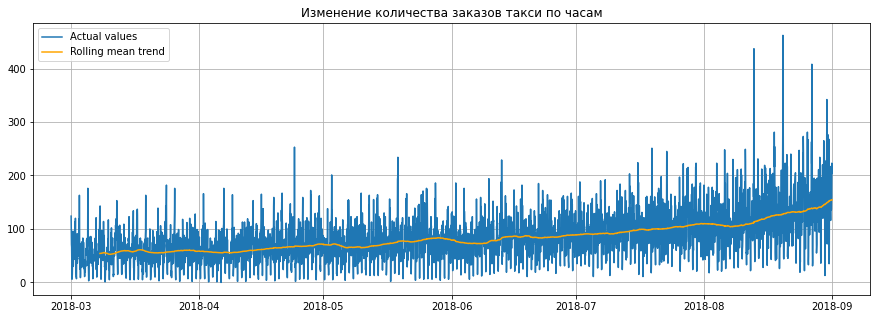

In [7]:
rolling_mean = df.rolling(24*7).mean()

plt.figure(figsize=(15,5))
plt.title("Изменение количества заказов такси по часам")

plt.plot(df, label="Actual values")
plt.plot(rolling_mean, "g", label="Rolling mean trend", color='orange')
plt.legend(loc="upper left")
plt.grid(True)

Благодаря скользящему среднему с размером окна в 1 неделю мы видим, что происходит непрерывный рост количества заказов такси. Скорей всего взяты данные по заказам такси города, часто посещаемого туристами.

Посмотрим тренды и сезонность.

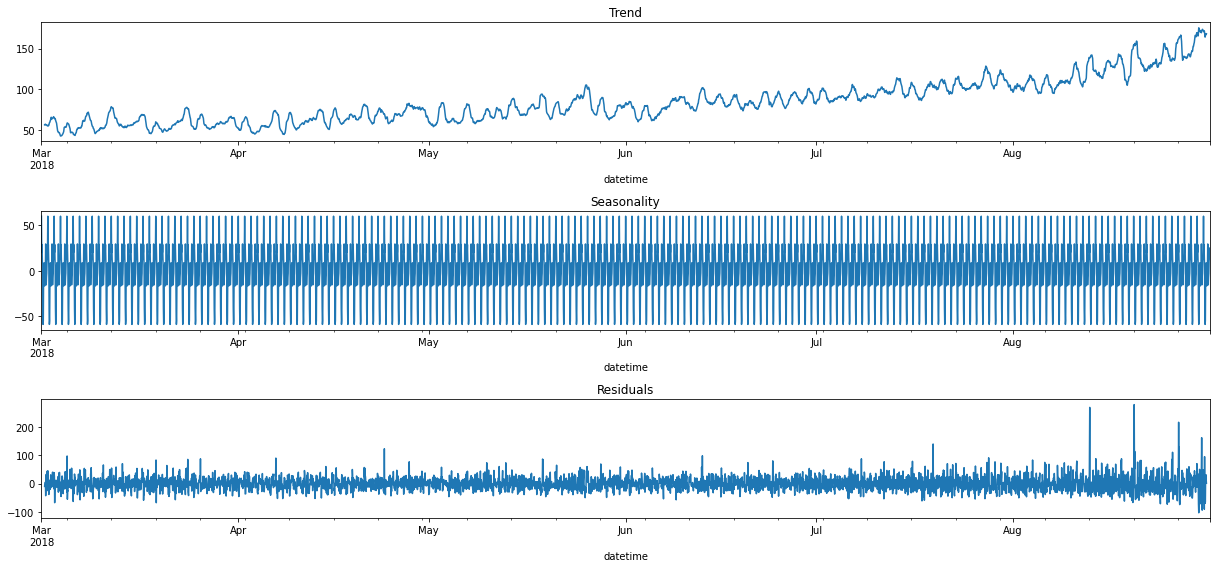

In [8]:
decomposed = seasonal_decompose(df) 

plt.figure(figsize=(17, 8))
plt.subplot(311)
# Чтобы график корректно отобразился, указываем его
# оси ax, равными plt.gca() (англ. get current axis,
# получить текущие оси)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

График тренда подтвердил выявленную возрастающую зависимость. График сезонности скорей всего показывает сезонность внутри одного дня. Посмотрим его детальнее.

<AxesSubplot:title={'center':'Сезонность заказов в течение 7 дней'}, xlabel='datetime'>

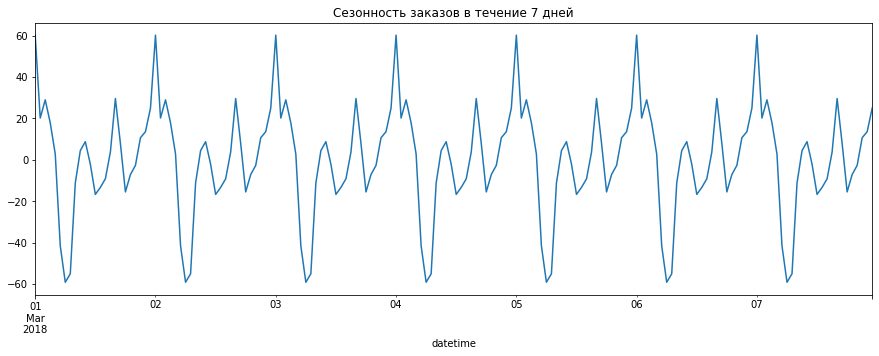

In [9]:
plt.figure(figsize=(15,5))
plt.title("Сезонность заказов в течение 7 дней")
decomposed.seasonal['2018-03-01':'2018-03-7'].plot(ax=plt.gca())

Сезонность в данном случае проявляется в одинаковом поведении заказов внутри одного дня: самый пик приходится на полночь - видимо люди возвращаются домой с гостей и мест отдыха, спад идет перед утренними часами и также значительное возрастание к вечернему времени - одни люди едут домой с работы, другие - отдыхать.

Проверим, можно ли назвать наш график стационарным, для этого используем тест Дики-Фуллера.

In [10]:
print('p-value гипотизы о нестационарности временного ряда составил', round(sm.tsa.stattools.adfuller(df['num_orders'])[1], 3))

p-value гипотизы о нестационарности временного ряда составил 0.029


В качестве критерия значимости примем 5 %, поэтому будем считать график стационарным.

Вывод: пропусков в данных нет, временной ряд монотонен и стационарен, предобработка данных не требуется. Также был выделен тренд имеющий возрастающую зависимость от времени и сезонность по дням. Переходим к подготовке выборок и обучению моделей.

## Обучение

Создадим дополнительные признаки для последующего обучения моделей. Т.к. стоит задача краткосрочного прогноза (на час вперед), то такие признаки как день недели, месяц и год включать не будем. Добавим лаги на 24 часа, скользяещее среднее с горизонтом в 7 часов, час и день.

In [11]:
def make_features(df, max_lag, rolling_mean_size):
    data = df.copy()
    data['hour'] = data.index.hour
    data['dayofweek'] = data.index.dayofweek
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
    return data

In [12]:
df_1 = make_features(df, 2, 24)

In [13]:
df_1.head(25)

,num_orders,hour,dayofweek,rolling_mean,lag_1,lag_2
datetime,,,,,,
2018-03-01 00:00:00,124,0,3,NaN,NaN,NaN
2018-03-01 01:00:00,85,1,3,NaN,124.000,NaN
2018-03-01 02:00:00,71,2,3,NaN,85.000,124.000
2018-03-01 03:00:00,66,3,3,NaN,71.000,85.000
2018-03-01 04:00:00,43,4,3,NaN,66.000,71.000
2018-03-01 05:00:00,6,5,3,NaN,43.000,66.000
2018-03-01 06:00:00,12,6,3,NaN,6.000,43.000
2018-03-01 07:00:00,15,7,3,NaN,12.000,6.000
2018-03-01 08:00:00,34,8,3,NaN,15.000,12.000


Разделим данные на обучающую и тестовые выборки и проверим корректность деления.

In [14]:
train, test = train_test_split(df_1, shuffle=False, test_size=0.1)

print(train.index.min(), train.index.max())
print(test.index.min(), test.index.max())

2018-03-01 00:00:00 2018-08-13 13:00:00
2018-08-13 14:00:00 2018-08-31 23:00:00


Деление произведено корректно. Избавимся от пропусков в трейне.

In [15]:
train.dropna(inplace=True)

In [16]:
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3950 entries, 2018-03-02 00:00:00 to 2018-08-13 13:00:00
Freq: H
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   num_orders    3950 non-null   int64  
 1   hour          3950 non-null   int64  
 2   dayofweek     3950 non-null   int64  
 3   rolling_mean  3950 non-null   float64
 4   lag_1         3950 non-null   float64
 5   lag_2         3950 non-null   float64
dtypes: float64(3), int64(3)
memory usage: 216.0 KB


Создадим обучающие и целевой признак.

In [17]:
target_train = train['num_orders']
features_train = train.drop('num_orders', axis=1)
target_test = test['num_orders']
features_test = test.drop('num_orders', axis=1)

Создадим функцию для вычисления метрики RMSE. Далее она будет использована при подборе гиперпраметров.

In [18]:
def rmse_score (target, predictions):
    rmse = mean_squared_error(target, predictions)**0.5
    return rmse
scorer = make_scorer(rmse_score, greater_is_better=False)

Переходим к обучению различных моделей. Проверим действие 4-х моделей: линейная регрессия, случайный лес, LightGBM, CatBoost. Поиск гиперпараметров будем проводить с помощью метода RandoSearchCV и метода TimeSeriesSplit.

### Линейная регрессия

In [19]:
tscv = TimeSeriesSplit(n_splits=8)

In [20]:
model = LinearRegression()
parameters = {'fit_intercept':[True,False], 'normalize':[True,False]}
grid = RandomizedSearchCV(model, parameters, cv=tscv, scoring=scorer, verbose=5, n_jobs=-1)
grid.fit(features_train, target_train)
print("RMSE линейной регрессии составляет ", -grid.best_score_)
print('Наилучшие подобранные параметры для линейной регрессии')
grid.best_params_

Fitting 8 folds for each of 4 candidates, totalling 32 fits
[CV 1/8] END .............fit_intercept=True, normalize=True; total time=   0.0s
[CV 2/8] END .............fit_intercept=True, normalize=True; total time=   0.0s
[CV 3/8] END .............fit_intercept=True, normalize=True; total time=   0.0s
[CV 4/8] END .............fit_intercept=True, normalize=True; total time=   0.0s
[CV 5/8] END .............fit_intercept=True, normalize=True; total time=   0.0s
[CV 6/8] END .............fit_intercept=True, normalize=True; total time=   0.0s
[CV 7/8] END .............fit_intercept=True, normalize=True; total time=   0.0s
[CV 8/8] END .............fit_intercept=True, normalize=True; total time=   0.0s
[CV 1/8] END ............fit_intercept=True, normalize=False; total time=   0.0s
[CV 2/8] END ............fit_intercept=True, normalize=False; total time=   0.0s
[CV 3/8] END ............fit_intercept=True, normalize=False; total time=   0.0s
[CV 4/8] END ............fit_intercept=True, norm

{'normalize': True, 'fit_intercept': False}

Наилучший RMSE 31.36 получен для параметров: 'fit_intercept': False, 'normalize': True.

### Случайный лес

In [21]:
forest = RandomForestRegressor(random_state=12345)
    
forest_params = {'n_estimators': range(30, 151, 10),
                 'max_depth': range(1,15)}

forest_grid = RandomizedSearchCV(forest, forest_params, cv=tscv, 
                                 scoring=scorer, verbose=5, n_jobs=-1)
forest_grid.fit(features_train, target_train)

print("RMSE для случайного леса составляет ", -forest_grid.best_score_)


print('Наилучшие подобранные параметры для случайного леса')
print(forest_grid.best_params_)

Fitting 8 folds for each of 10 candidates, totalling 80 fits
[CV 1/8] END ..................max_depth=12, n_estimators=80; total time=   0.2s
[CV 2/8] END ..................max_depth=12, n_estimators=80; total time=   0.2s
[CV 3/8] END ..................max_depth=12, n_estimators=80; total time=   0.3s
[CV 4/8] END ..................max_depth=12, n_estimators=80; total time=   0.3s
[CV 5/8] END ..................max_depth=12, n_estimators=80; total time=   0.4s
[CV 6/8] END ..................max_depth=12, n_estimators=80; total time=   0.5s
[CV 7/8] END ..................max_depth=12, n_estimators=80; total time=   0.5s
[CV 8/8] END ..................max_depth=12, n_estimators=80; total time=   0.6s
[CV 1/8] END ..................max_depth=13, n_estimators=40; total time=   0.1s
[CV 2/8] END ..................max_depth=13, n_estimators=40; total time=   0.1s
[CV 3/8] END ..................max_depth=13, n_estimators=40; total time=   0.1s
[CV 4/8] END ..................max_depth=13, n_e

Наилучший RMSE 24.587 для случайного леса получен для параметров: 'max_depth': 14, 'n_estimators': 130

### Light GBM

In [22]:
gbm = LGBMRegressor(random_state=12345)
    
g_params = {'n_estimators': [50, 100, 500],
              'num_leaves': [21, 31, 41], 
              'learning_rate':[0.01, .04, 0.06]}

g_grid = RandomizedSearchCV(gbm, g_params,
                         cv=tscv, verbose=5, scoring=scorer)

g_grid.fit(features_train, target_train)

print("RMSE для LGBM составляет ", -g_grid.best_score_)


print('Наилучшие подобранные параметры для LGBM')
print(g_grid.best_params_)

Fitting 8 folds for each of 10 candidates, totalling 80 fits
[CV 1/8] END learning_rate=0.04, n_estimators=100, num_leaves=41; total time=  37.1s
[CV 2/8] END learning_rate=0.04, n_estimators=100, num_leaves=41; total time=   6.4s
[CV 3/8] END learning_rate=0.04, n_estimators=100, num_leaves=41; total time=   0.9s
[CV 4/8] END learning_rate=0.04, n_estimators=100, num_leaves=41; total time=   1.0s
[CV 5/8] END learning_rate=0.04, n_estimators=100, num_leaves=41; total time=   1.2s
[CV 6/8] END learning_rate=0.04, n_estimators=100, num_leaves=41; total time=   2.4s
[CV 7/8] END learning_rate=0.04, n_estimators=100, num_leaves=41; total time=   1.0s
[CV 8/8] END learning_rate=0.04, n_estimators=100, num_leaves=41; total time=   1.0s
[CV 1/8] END learning_rate=0.04, n_estimators=50, num_leaves=21; total time=   0.2s
[CV 2/8] END learning_rate=0.04, n_estimators=50, num_leaves=21; total time=   0.3s
[CV 3/8] END learning_rate=0.04, n_estimators=50, num_leaves=21; total time=   0.3s
[CV 4/8

Наилучший RMSE 24.36 для LGBM получен для параметров: 'learning_rate': 0.01, 'n_estimators': 500, 'num_leaves': 31.

### CatBoost

In [24]:
cbr = CatBoostRegressor(loss_function="RMSE")

grid = {'learning_rate': [0.03, 0.1, 0.5],
        'iterations': [150, 500]}

cbr_grid = RandomizedSearchCV(cbr, grid,
                         cv=tscv, verbose=5, scoring=scorer)

cbr_grid.fit(features_train, target_train)

print("RMSE для CBR составляет ", -cbr_grid.best_score_)


print('Наилучшие подобранные параметры для CBR')
print(cbr_grid.best_params_)

Fitting 8 folds for each of 6 candidates, totalling 48 fits
0:	learn: 28.8324272	total: 46.9ms	remaining: 6.98s
1:	learn: 28.4831086	total: 47.4ms	remaining: 3.51s
2:	learn: 28.1253916	total: 48ms	remaining: 2.35s
3:	learn: 27.7011279	total: 48.7ms	remaining: 1.78s
4:	learn: 27.3417925	total: 49.3ms	remaining: 1.43s
5:	learn: 27.0303774	total: 49.9ms	remaining: 1.2s
6:	learn: 26.7348141	total: 50.4ms	remaining: 1.03s
7:	learn: 26.5057308	total: 50.9ms	remaining: 904ms
8:	learn: 26.1506253	total: 51.4ms	remaining: 806ms
9:	learn: 25.8371440	total: 52ms	remaining: 729ms
10:	learn: 25.6092542	total: 52.6ms	remaining: 664ms
11:	learn: 25.2796329	total: 53.2ms	remaining: 612ms
12:	learn: 24.9734625	total: 53.9ms	remaining: 568ms
13:	learn: 24.7686577	total: 54.4ms	remaining: 528ms
14:	learn: 24.4906594	total: 54.8ms	remaining: 494ms
15:	learn: 24.2055860	total: 55.3ms	remaining: 464ms
16:	learn: 23.9298071	total: 55.9ms	remaining: 438ms
17:	learn: 23.6323117	total: 56.6ms	remaining: 415ms
1

Наилучший RMSE 24.602 для CBR получен для параметров: 'iterations': 150, 'learning_rate': 0.1.

Обучены и подобраны гиперпараметры для 4 различных моделей: линейная регрессия, случайный лес, CatBoost, LightGBM. Для всех моделей была применена кросс-валидация с применением метода TimeSeriesSplit.

Целевое значение метрики RMSE (<48) достигнуты всеми 4-мя моделями. Наихудший результат был получен с ппомощью линейной регрессии (31.36), наилучший - с помощью LGBM (24.36). Проверим модели с подобранными гиперпараметрами на тестовой выборке.

## Тестирование

In [25]:
# создадим таблицу для хранения результатов
d = {'model': [], 'RMSE':[], 'fit_time': [], 'predict_time':[]}
results = pd.DataFrame(data=d)
results

,model,RMSE,fit_time,predict_time


In [26]:
# создадим функцию для добавления результатов в таблицу
def model_res(model_name, model, features_train, target_train, features_test, target_test):
    rmse, fit_time, pred_time = ml(model, features_train, target_train, features_test, target_test)
    results.loc[len(results)] = [model_name, rmse, fit_time, pred_time]
    if len(results) > 0: # исключим дублировании при неоднократном выполнении функции для одной и той же модели
        results.drop_duplicates(inplace=True)

In [27]:
# cоздадим функцию для расчета необходимых параметров
def ml (model, features_train, target_train, features_test, target_test):
    start_fit_time = time.time()
    model.fit(features_train, target_train)
    stop_fit_time = time.time()
    
    fit_time = stop_fit_time - start_fit_time
    
    start_predict_time = time.time()
    predictions = model.predict(features_test)
    
    stop_predict_time = time.time()
    
    pred_time = stop_predict_time - start_predict_time
    
    rmse = mean_squared_error(target_test, predictions)**0.5
    
    return rmse, fit_time, pred_time

In [28]:
# создадим функцию для вывода графиков
def plot_test (model, model_name):
    plt.figure(figsize=(15,5))
    plt.title("Сравнение реальных значений и предсказанных с помощью модели " + model_name)
    plt.plot(target_test, label='Test values')
    predictions = model.predict(features_test)
    predictions = pd.Series(predictions, index=target_test.index)
    plt.plot(predictions, label ='Prediction values')
    plt.legend(loc="upper left")
    plt.grid(True)

,model,RMSE,fit_time,predict_time
0,LinearRegression,51.192,0.004,0.002


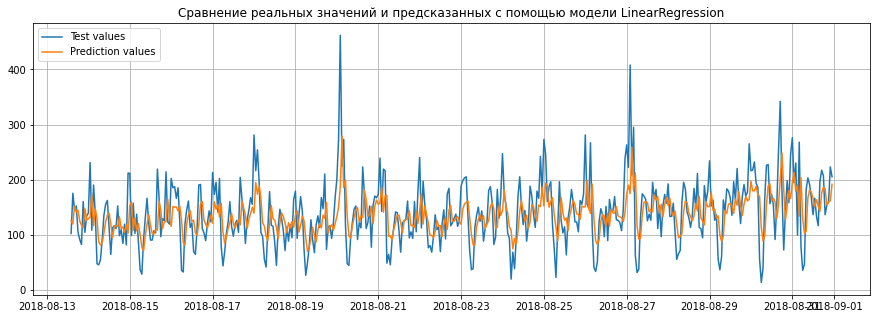

In [29]:
# линейная регрессия
lr = LinearRegression(fit_intercept=False, normalize=True)
model_res('LinearRegression', lr,  features_train, target_train,
          features_test, target_test)
display(results)
plot_test(lr, 'LinearRegression')

На тестовой выборке линейная регрессия показала намного меньший результат, чем на трейне, и вывалилась за предельное значение метрики. График показывает, что, в основном, линейная регрессия больше всего ошибается в точках максимумов и минимумов.

,model,RMSE,fit_time,predict_time
0,LinearRegression,51.192,0.004,0.002
1,RandomForestRegressor,46.718,1.300,0.020


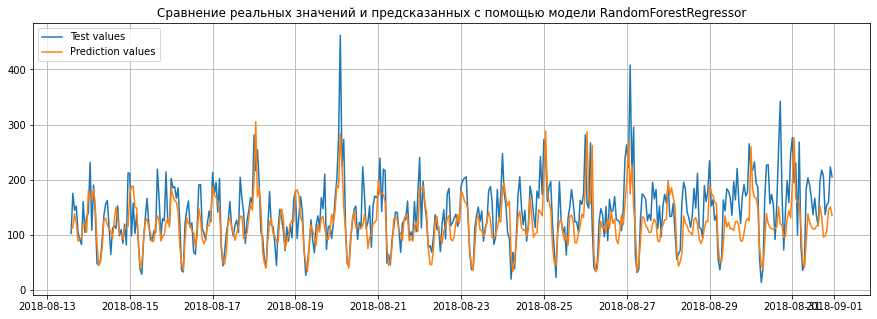

In [30]:
# случайный лес
rf = RandomForestRegressor(max_depth=14, n_estimators=150, random_state=12345)
model_res('RandomForestRegressor', rf,  features_train, target_train,
          features_test, target_test)
display(results)
plot_test(rf, 'RandomForestRegressor')

Метрика случайного леса получилась лучше, чем у линейной регрессии, и вошла в допустимый интервал.

,model,RMSE,fit_time,predict_time
0,LinearRegression,51.192,0.004,0.002
1,RandomForestRegressor,46.718,1.300,0.020
2,LGBMRegressor,45.082,4.761,0.012


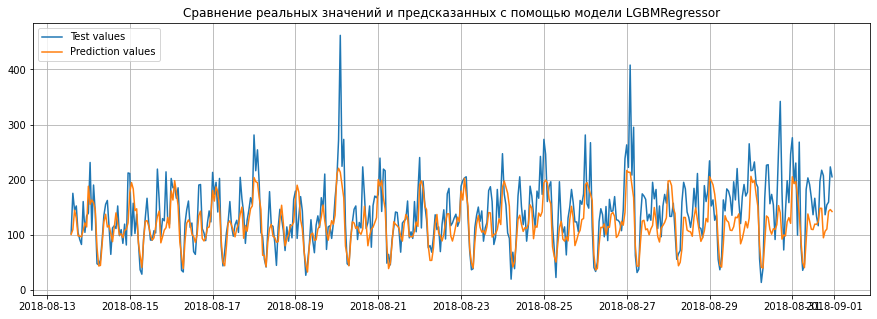

In [31]:
# Light GBM
lgbm = LGBMRegressor(learning_rate=0.01, n_estimators=500, num_leaves=41, random_state=12345)
model_res('LGBMRegressor', lgbm,  features_train, target_train,
          features_test, target_test)
display(results)
plot_test(lgbm, 'LGBMRegressor')

RMSE у LGBM почти такая же как у случайного леса, а скорость обучения в 2 раза больше, поэтому в качестве лидера пока можно выделить случайный лес.

0:	learn: 38.0839188	total: 1.46ms	remaining: 731ms
1:	learn: 37.5599621	total: 2.76ms	remaining: 687ms
2:	learn: 37.0857594	total: 4.63ms	remaining: 768ms
3:	learn: 36.6055784	total: 5.88ms	remaining: 729ms
4:	learn: 36.1223956	total: 7.04ms	remaining: 697ms
5:	learn: 35.7032658	total: 8.27ms	remaining: 681ms
6:	learn: 35.2992283	total: 9.34ms	remaining: 658ms
7:	learn: 34.8873800	total: 10.4ms	remaining: 642ms
8:	learn: 34.4810575	total: 11.6ms	remaining: 631ms
9:	learn: 34.1085164	total: 12.7ms	remaining: 624ms
10:	learn: 33.7147967	total: 14ms	remaining: 622ms
11:	learn: 33.3666613	total: 15.1ms	remaining: 613ms
12:	learn: 33.0015923	total: 16.4ms	remaining: 613ms
13:	learn: 32.7239535	total: 17.5ms	remaining: 609ms
14:	learn: 32.3654645	total: 18.8ms	remaining: 609ms
15:	learn: 32.0235319	total: 20.1ms	remaining: 607ms
16:	learn: 31.7140120	total: 21.4ms	remaining: 608ms
17:	learn: 31.4655993	total: 22.6ms	remaining: 605ms
18:	learn: 31.1636224	total: 23.9ms	remaining: 604ms
19:	l

,model,RMSE,fit_time,predict_time
0,LinearRegression,51.192,0.004,0.002
1,RandomForestRegressor,46.718,1.300,0.020
2,LGBMRegressor,45.082,4.761,0.012
3,CatBoostRegressor,46.903,1.144,0.001


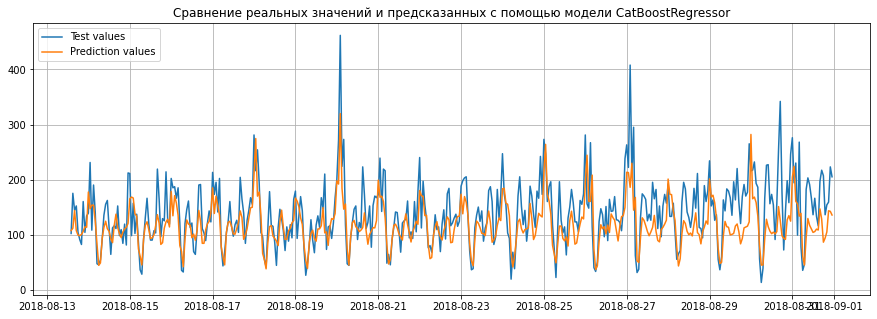

In [32]:
# CatBoost
cb = CatBoostRegressor(loss_function="RMSE",
                         learning_rate=0.03, 
                         iterations=500,
                         random_state=12345)
model_res('CatBoostRegressor', cb,  features_train, target_train,
          features_test, target_test)
display(results)
plot_test(cb, 'CatBoostRegressor')

По итогу тестирования все модели, кроме линейной регрессии, подошли под требование по поставленной метрике (RMSE < 48). тем не менее каждая модель оказалась переобученной (или недообученной), т.к. результаты на тестовой выборке ухудшились почти в 1.5 раза для каждой модели по сравнению с обучающей.

**Вывод**
Модель с лучшими параметрами (метрика + скорость обучения) оказался случайный лес.